## What is `kerchunk`?

- Kerchunk is a library that provides a unified way to represent a variety of chunked, compressed data formats (e.g. NetCDF/HDF5, GRIB2, TIFF, …).
- Works on traditional filesystems or on cloud storage.
- Allows to create __virtual datasets from multiple files__, by extracting the byte ranges, compression information and other information about the data and storing this metadata in a new, separate object.
- Bridges the gap between new, cloud-friendly formats and legacy formats for data storage.

Also: just a faster alternative to `xarray.open_mfdataset` for large number of files

In [1]:
# you must have a recent eccodes installation available
import os
os.environ["ECCODES_DIR"] = "~/local/eccodes"

# also the cosmo definitions
os.environ["ECCODES_DEFINITION_PATH"] = "~/local/eccodes-cosmo-resources/definitions"

In [2]:
import xarray as xr
import fsspec
from kerchunk.combine import MultiZarrToZarr

from grixraz import find_files, create_references

### KENDA-1 analysis as a virtual zarr store
Let's say we want to represent the archived KENDA-1 analysis as a zarr store. In this example we will only consider one month, but in principle we could consider the entire archive.

The key idea is that once the "virtual map" has been created (which does take some time, because we have to scan all the grib files), most of the work is done. The files containing the information are stored and will be reused, they will work unless of course the original data is moved or deleted.

In [3]:
PATH = "/store/s83/osm/KENDA-1/ANASURF23/det/lafsurf202306*"
files = find_files(PATH)
print(f"Found {len(files)} files")
files[:5]


Found 720 files


['/store/s83/osm/KENDA-1/ANASURF23/det/lafsurf2023060100_det',
 '/store/s83/osm/KENDA-1/ANASURF23/det/lafsurf2023060101_det',
 '/store/s83/osm/KENDA-1/ANASURF23/det/lafsurf2023060102_det',
 '/store/s83/osm/KENDA-1/ANASURF23/det/lafsurf2023060103_det',
 '/store/s83/osm/KENDA-1/ANASURF23/det/lafsurf2023060104_det']

### Generating references
In the following step we generate json files as references to the original grib files, but in a zarr specification. Every reference contains information about the shape of the array, the byte ranges, the attributes, coordinates, etc. 

For simplicity, we also filter the grib files and only consider 2m and 10m variables (this will be surface temperature and suface wind).

In [4]:
# should take about 1 minute
filter = {"typeOfLevel": "heightAboveGround", "level": [2, 10]}
ref_files = create_references(files, n_workers=20, filter=filter)

Creating references...:   0%|          | 0/720 [00:00<?, ?it/s]

### Combining all references into a single, consolidated zarr store
Now that the heavy lifting is done, we can just work with our reference json files to combine them in the proper way.

In [6]:
mzz = MultiZarrToZarr(ref_files,
                        concat_dims = ['valid_time'],
                        identical_dims=['latitude', 'longitude', 'heightAboveGround', 'step'])
d = mzz.translate()

### And as usual...open with xarray!
This is practically instantaneous (as opposed to `xr.open_mfdataset`). To xarray we are opening a simple zarr archive. As already said, the fundamental advantage is that we create the virtual map (the reference files) only once and not every time we want to consume this data.

In [7]:
#open dataset as zarr object using fsspec reference file system and xarray
# with "reference" protocol we view byte ranges of some other file as a file system
fs = fsspec.filesystem("reference", fo=d, remote_options={'anon':True})
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False), 
                      chunks={'valid_time':1})
ds

<xarray.Dataset>
Dimensions:            (valid_time: 720, y: 786, x: 1170)
Coordinates:
    heightAboveGround  float64 ...
    latitude           (y, x) float64 dask.array<chunksize=(786, 1170), meta=np.ndarray>
    longitude          (y, x) float64 dask.array<chunksize=(786, 1170), meta=np.ndarray>
    step               timedelta64[ns] ...
    time               (valid_time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * valid_time         (valid_time) datetime64[ns] 2023-06-01 ... 2023-06-30T...
Dimensions without coordinates: y, x
Data variables:
    d2m                (valid_time, y, x) float64 dask.array<chunksize=(1, 786, 1170), meta=np.ndarray>
    t2m                (valid_time, y, x) float64 dask.array<chunksize=(1, 786, 1170), meta=np.ndarray>
    u10                (valid_time, y, x) float64 dask.array<chunksize=(1, 786, 1170), meta=np.ndarray>
    v10                (valid_time, y, x) float64 dask.array<chunksize=(1, 786, 1170), meta=np.ndarray>
Attributes:
    GRIB_centre:             lssw
    GRIB_centreDescription:  Zurich
    GRIB_edition:            2
    GRIB_subCentre:          255
    institution:             Zurich

That's it! We can read our GRIB archive just like a zarr store, where each timestep is one chunk. The GRIB files are still in their original location, we haven't created any copy, instead we have mapped them to a zarr representation.

In [8]:
t2m = ds["t2m"].sel(valid_time=slice("2023-06-01", "2023-06-04")).persist()
t2m

<xarray.DataArray 't2m' (valid_time: 96, y: 786, x: 1170)>
dask.array<getitem, shape=(96, 786, 1170), dtype=float64, chunksize=(1, 786, 1170), chunktype=numpy.ndarray>
Coordinates:
    heightAboveGround  float64 ...
    latitude           (y, x) float64 dask.array<chunksize=(786, 1170), meta=np.ndarray>
    longitude          (y, x) float64 dask.array<chunksize=(786, 1170), meta=np.ndarray>
    step               timedelta64[ns] ...
    time               (valid_time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * valid_time         (valid_time) datetime64[ns] 2023-06-01 ... 2023-06-04T...
Dimensions without coordinates: y, x
Attributes: (12/32)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1170
    GRIB_Ny:                                  786
    GRIB_angleOfRotationInDegrees:            0.0
    GRIB_cfName:                              air_temperature
    GRIB_cfVarName:                           t2m
    ...                                       ...
    GRIB_stepUnits:                           1
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_units:                               K
    long_name:                                2 metre temperature
    standard_name:                            air_temperature
    units:                                    K

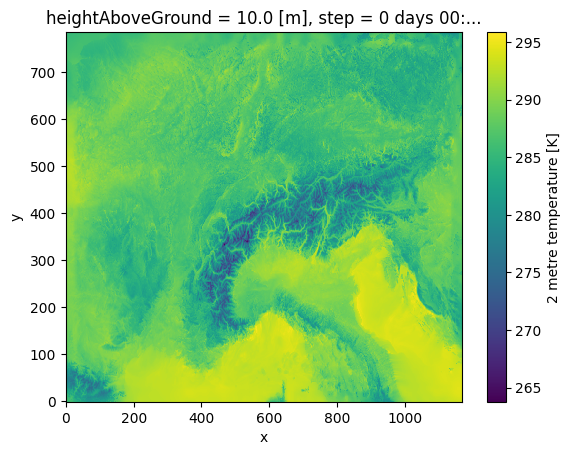

In [9]:
t2m[0].plot() # yay!

In principle, we could reference every KENDA-1 file stored at CSCS, and with a bit of extra work (e.g. for CF-decoding, regridding, etc.) we could have our nice virtual zarr store for the entire KENDA-1 archive. It's a low hanging fruit.